In [1]:
#load libraries
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 


C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#load folder-the actual data were given in 17 separate excel files
files = os.listdir('dataLoad')
files

['Cons_Report_012018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_062019.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_072019.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_122018.xlsx',
 'Load Demand_Forecast.xlsx']

In [3]:
#list of files to loop-only xlsx
files_xls = [f for f in files if 'Cons_Report' in f]
files_xls

['Cons_Report_012018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_062019.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_072019.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_122018.xlsx']

In [4]:
#create one dataframe from all the excel files
actual = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('dataLoad/' + f)
    actual=actual.append(data, ignore_index=True)

In [5]:
#get column names
actual.columns

Index(['deliveryDay', 'Hour_EET', 'Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network',
       'Total'],
      dtype='object')

In [6]:
#rename columns
actual.columns=['Date','Hour','Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network','ActualTotal']
actual.head()

,Date,Hour,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,2018-01-01,1,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2018-01-01,2,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645
2,2018-01-01,3,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316
3,2018-01-01,4,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808
4,2018-01-01,5,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510


In [7]:
#load excel with forecast of the current program
forecast=pd.read_excel("dataLoad/Load Demand_Forecast.xlsx")

In [8]:
#data manipulation to create new dataframe
forecast2=forecast[['Weekday',  'Holiday','Date', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
prediction = pd.melt(forecast2, id_vars=["Weekday", "Holiday", "Date"])
prediction.head(10)

,Weekday,Holiday,Date,variable,value
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [9]:
#rename columns
prediction.columns=[ 'Weekday', 'Holiday', 'Date', 'Hour', 'ForecastTotalLoad' ]
prediction.head(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [10]:
#subtract one hour to get to 0-23 hour format
actual['Hour']=actual['Hour']-1
prediction['Hour']=prediction['Hour']-1

In [11]:
#set index
actual.set_index(['Date', 'Hour']).head()

Gen_Aux          HV     Pump      TEL_MV      Network  \
Date       Hour                                                            
2018-01-01 0     34.418093  757.020147    0.000  596.563993  4529.773678   
           1     40.928810  760.024989    0.000  589.266551  4205.128845   
           2     39.286246  750.624526    0.000  585.334471  4116.742544   
           3     38.678094  756.567856    0.120  582.210175  3833.136857   
           4     37.498531  731.949138  130.176  581.251131  3608.455842   

                 ActualTotal  
Date       Hour               
2018-01-01 0     5321.211918  
           1     5006.082645  
           2     4906.653316  
           3     4628.502808  
           4     4508.079510

In [12]:
#set index
prediction.set_index(['Date', 'Hour']).head()

,,Weekday,Holiday,ForecastTotalLoad
Date,Hour,,,
2018-01-01,0,1,1,5315.0
2018-01-02,0,2,0,5023.0
2018-01-03,0,3,0,5211.0
2018-01-04,0,4,0,5307.0
2018-01-05,0,5,0,5420.0


In [13]:
#merge datasets
final = pd.merge(prediction, actual, on=['Date', 'Hour'])
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090


In [14]:
#create Timestamp column
final['Timestamp'] = final['Date'] + pd.to_timedelta(final['Hour'], unit='h')
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985,2018-01-02
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667,2018-01-03
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647,2018-01-04
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090,2018-01-05


In [15]:
#sort by timestamp
final.sort_values('Timestamp', inplace=True)
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 00:00:00
577,1,1,2018-01-01,1,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 01:00:00
1154,1,1,2018-01-01,2,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 02:00:00
1731,1,1,2018-01-01,3,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 03:00:00
2308,1,1,2018-01-01,4,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 04:00:00


In [16]:
#create the column of interest
final['XT'] = final['Network'] - final['TEL_MV']

#find the percentage of XT as to total ActualLoad for that day and Hour (TrueValues)
final['%XTofTotal']=final['XT']/final['ActualTotal']

#find the estimation of XTPrediction
final['XTForecastEstimation']=final['%XTofTotal']*final['ForecastTotalLoad']


In [17]:
#finalize dataset and set frequency
final=final[['Timestamp','XT','Weekday','Holiday','XTForecastEstimation']]
final.sort_values('Timestamp', inplace=True)
final.set_index('Timestamp', inplace=True)

In [18]:
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-07-31 14:00:00', '2019-07-31 15:00:00',
               '2019-07-31 16:00:00', '2019-07-31 17:00:00',
               '2019-07-31 18:00:00', '2019-07-31 19:00:00',
               '2019-07-31 20:00:00', '2019-07-31 21:00:00',
               '2019-07-31 22:00:00', '2019-07-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=13846, freq=None)

In [19]:
#check for missing values
pd.date_range(final.index.min(), final.index.max(), freq='H').difference(final.index)

DatetimeIndex(['2018-03-25 23:00:00', '2019-03-31 23:00:00'], dtype='datetime64[ns]', freq=None)

In [20]:
#set Hourly index frequency
final = final.asfreq(freq='H', method='pad')
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-07-31 14:00:00', '2019-07-31 15:00:00',
               '2019-07-31 16:00:00', '2019-07-31 17:00:00',
               '2019-07-31 18:00:00', '2019-07-31 19:00:00',
               '2019-07-31 20:00:00', '2019-07-31 21:00:00',
               '2019-07-31 22:00:00', '2019-07-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=13848, freq='H')

In [21]:
#check again for NaN in dataframe γιατι τώρα που κουβαλάω και την επιπλέον στήλη εχω το ίδιο θέμα με την ώρα
final[final.isnull().any(axis=1)]

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 03:00:00,2507.887529,7,1,NaN


In [22]:
#NaN that day for forecastedValues
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation            NaN
Name: 2018-03-25 03:00:00, dtype: float64

In [23]:
#fill with previous value ΝαΝ
final=final.fillna(method='ffill')

In [24]:
#fixed
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation    2648.583949
Name: 2018-03-25 03:00:00, dtype: float64

# Data Exploration

Text(0.5, 1.0, 'Low Voltage Consumption VS Holiday')

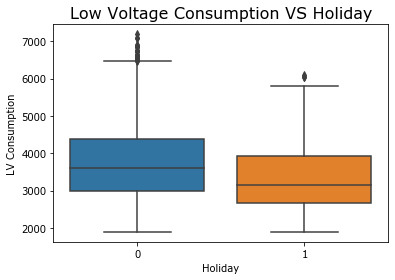

In [25]:
#Here is going to be the EDA part-just some quick insights
import seaborn as sns
sns.boxplot(x=final['Holiday'],y=final['XT']).set(ylabel='LV Consumption',xlabel='Holiday')
plt.title('Low Voltage Consumption VS Holiday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Consumption VS Weekday')

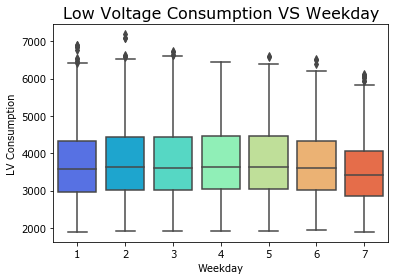

In [26]:
sns.boxplot(x=final['Weekday'],y=final['XT'],palette='rainbow').set(ylabel='LV Consumption',xlabel='Weekday')
plt.title('Low Voltage Consumption VS Weekday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Consumption')

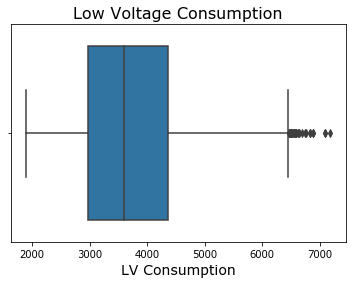

In [27]:
#there are some outliers
sns.boxplot(x=final['XT']).set_xlabel('LV Consumption',fontsize=14)
plt.title('Low Voltage Consumption',fontsize=16)


In [28]:
#check largest Values-seems logical not extreme values
print( final['XT'].nlargest(100))

Timestamp
2019-01-08 19:00:00    7187.273484
2019-01-08 18:00:00    7092.001648
2019-01-08 20:00:00    7087.291997
2019-01-07 19:00:00    6889.243639
2018-12-31 19:00:00    6886.460958
                          ...     
2019-07-09 18:00:00    6106.338999
2018-01-26 19:00:00    6104.612583
2019-01-07 11:00:00    6104.174324
2019-01-04 16:00:00    6103.586724
2018-01-25 18:00:00    6100.779307
Name: XT, Length: 100, dtype: float64


Text(0.5, 1.0, 'Daily Actual Consumption per Hour')

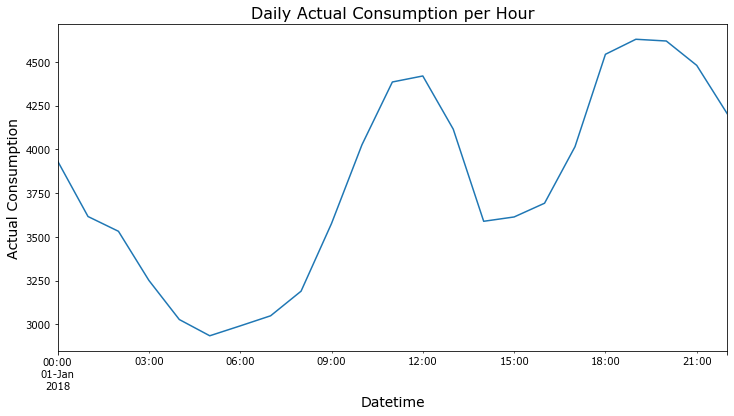

In [29]:
final['XT'].iloc[:23].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Actual Consumption', fontsize=14)
plt.title('Daily Actual Consumption per Hour', fontsize=16)

Text(0.5, 1.0, 'Actual Consumption (Historical Data)')

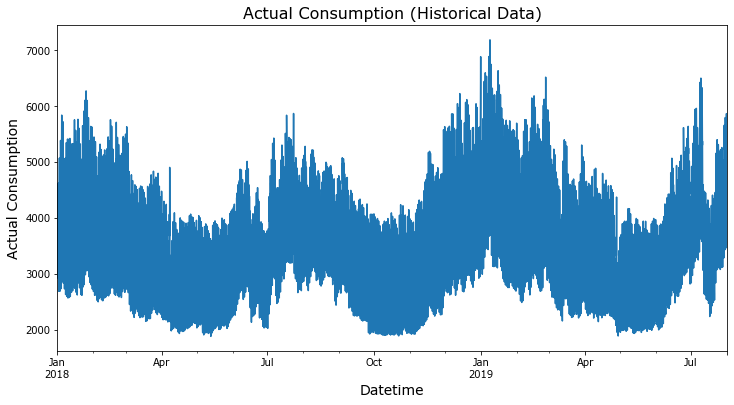

In [30]:
final['XT'].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Actual Consumption', fontsize=14)
plt.title('Actual Consumption (Historical Data)', fontsize=16)

Text(0, 0.5, 'Residual')

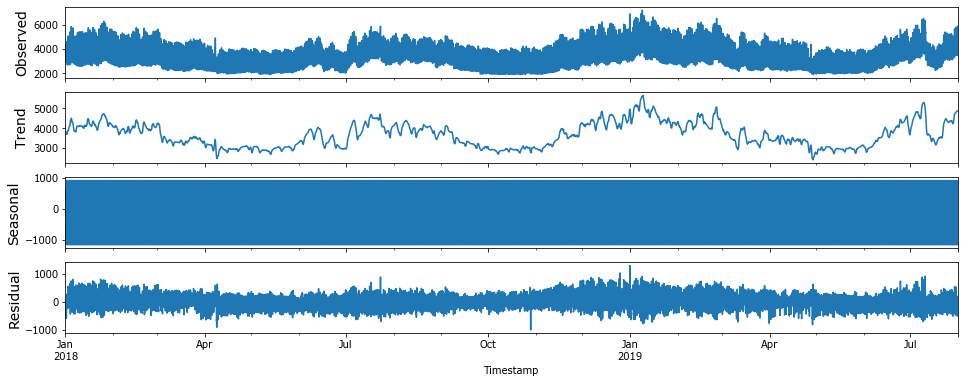

In [31]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16,6))

result = seasonal_decompose(final['XT'])

result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed',fontsize=14)
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend',fontsize=14)
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal',fontsize=14)
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual',fontsize=14)


In [32]:
#create ad-fuller test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [33]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

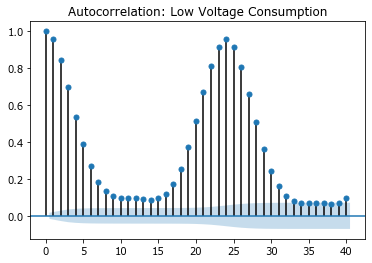

In [34]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Low Voltage Consumption'
lags = 40
plot_acf(final['XT'],title=title,lags=lags);

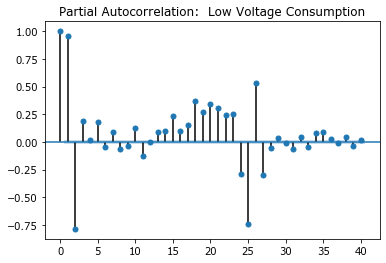

In [35]:
title='Partial Autocorrelation:  Low Voltage Consumption'
lags=40
plot_pacf(final['XT'],title=title,lags=lags);

In [36]:
#KPSS test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(series):
    print ('Results of KPSS Test:')
    kpsstest = kpss(series, regression='c', lags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [37]:
kpss_test(final['XT'])

Results of KPSS Test:
Test Statistic            1.019992
p-value                   0.010000
Lags Used                55.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [38]:
adf_test(final['XT'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.871747
p-value                     0.002253
# lags used                42.000000
# observations          13805.000000
critical value (1%)        -3.430824
critical value (5%)        -2.861749
critical value (10%)       -2.566881
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [39]:
final2=final

In [40]:
final2

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104
2018-01-01 01:00:00,3615.862294,1,1,3584.743969
2018-01-01 02:00:00,3531.408073,1,1,3481.997027
2018-01-01 03:00:00,3250.926682,1,1,3171.205588
2018-01-01 04:00:00,3027.204711,1,1,2874.047836
...,...,...,...,...
2019-07-31 19:00:00,5403.155909,3,0,5409.007315
2019-07-31 20:00:00,5409.958805,3,0,5398.877004
2019-07-31 21:00:00,5698.581309,3,0,5655.686732


# SARIMAX

In [41]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(final2['XT'], seasonal=True, m=24).summary()

C:\Users\User\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 0) seasonal_order=(2, 0, 1, 24); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 1) seasonal_order=(2, 0, 1, 24); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\Users\User\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 1, 1) seasonal_order=(2, 0, 1, 24); data is likely non-stationary. (if you do not 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                13848
Model:             SARIMAX(2, 1, 0)x(2, 0, 1, 24)   Log Likelihood              -75598.317
Date:                            Thu, 31 Oct 2019   AIC                         151210.633
Time:                                    00:23:13   BIC                         151263.384
Sample:                                         0   HQIC                        151228.204
                                          - 13848                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0178      0.058     -0.307      0.759      -0.132       0.096
ar.L1          0.7630      0.004    217.386      0.000       0.756       0.770
ar.L2         -0.3471      0.005    -76.292      0.000      -0.356      -0.338
ar.S.L24       1.2721      0.007    171.861      0.000       1.258       1.287
ar.S.L48      -0.2724      0.007    -36.879      0.000      -0.287      -0.258
ma.S.L24      -0.7728      0.005   -145.158      0.000      -0.783      -0.762
sigma2      3204.1300     16.077    199.295      0.000    3172.619    3235.641
===================================================================================
Ljung-Box (Q):                      905.56   Jarque-Bera (JB):            110667.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.62
Prob(H) (two-sided):                  0.53   Kurtosis:                        16.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
#use the period used for training
df1=final2
df1.shape

(13848, 4)

In [43]:
#train test split
train = df1.iloc[:-24]
test = df1.iloc[-24:]

In [44]:
#run model
model = SARIMAX(train['XT'],
                exog=train[['Holiday','Weekday']],
                order=(2, 1, 0),
                seasonal_order=(2, 0, 1, 24),initialization='approximate_diffuse',
                enforce_invertibility=False)
results = model.fit()
results.summary()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 XT   No. Observations:                13824
Model:             SARIMAX(2, 1, 0)x(2, 0, 1, 24)   Log Likelihood              -75516.021
Date:                            Thu, 31 Oct 2019   AIC                         151048.042
Time:                                    00:34:34   BIC                         151108.315
Sample:                                01-01-2018   HQIC                        151068.120
                                     - 07-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       27.9646      3.865      7.235      0.000      20.389      35.540
Weekday        0.7740      0.731      1.059      0.290      -0.659       2.207
ar.L1          0.7630      0.004    211.960      0.000       0.756       0.770
ar.L2         -0.3454      0.005    -74.558      0.000      -0.355      -0.336
ar.S.L24       1.2643      0.008    162.459      0.000       1.249       1.280
ar.S.L48      -0.2647      0.008    -34.644      0.000      -0.280      -0.250
ma.S.L24      -0.7676      0.006   -138.741      0.000      -0.778      -0.757
sigma2      3195.1977     16.602    192.460      0.000    3162.659    3227.737
===================================================================================
Ljung-Box (Q):                      906.33   Jarque-Bera (JB):            112353.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.63
Prob(H) (two-sided):                  0.14   Kurtosis:                        16.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Holiday','Weekday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, 
                              end=end, 
                              exog=exog_forecast).rename('SARIMAX(2,1,0)(2, 0, 1, 24) Predictions')

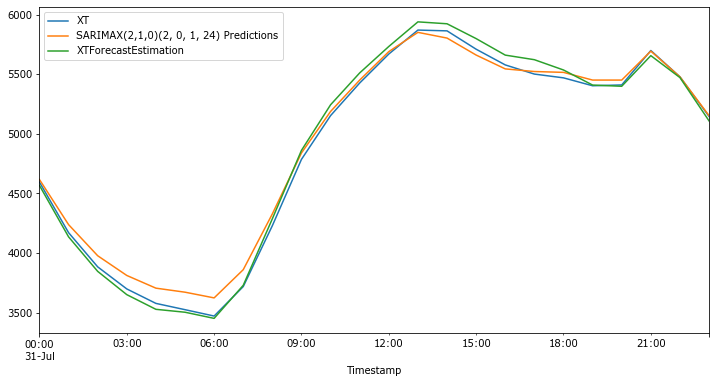

In [46]:
# Plot predictions against known values
ax = test['XT'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
final['XTForecastEstimation'].loc['2019-07-31'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [47]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(test['XT'], predictions)
TheirError = rmse(final['XTForecastEstimation'].loc['2019-07-31'], test['XT'])

In [48]:
TheirError

58.764376527697294

In [49]:
OurError

75.41435881867594

# Prophet

In [50]:
#import ProphetLibrary
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [51]:
#create holidays Dataframe for possible use by Prophet
holidays = pd.DataFrame({
    'ds': train.reset_index().query('Holiday == 1')['Timestamp'],
    'holiday': 'holiday'
})
holidays.head()

,ds,holiday
0,2018-01-01 00:00:00,holiday
1,2018-01-01 01:00:00,holiday
2,2018-01-01 02:00:00,holiday
3,2018-01-01 03:00:00,holiday
4,2018-01-01 04:00:00,holiday


In [52]:
#fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)#, holidays=holidays)
prophet_model.fit(train['XT'].reset_index().rename(columns={'Timestamp':'ds', 'XT':'y'}))

In [53]:
#predict
prophet_forecast = prophet_model.predict(df=test['XT'].reset_index().rename(columns={'Timestamp':'ds'}))

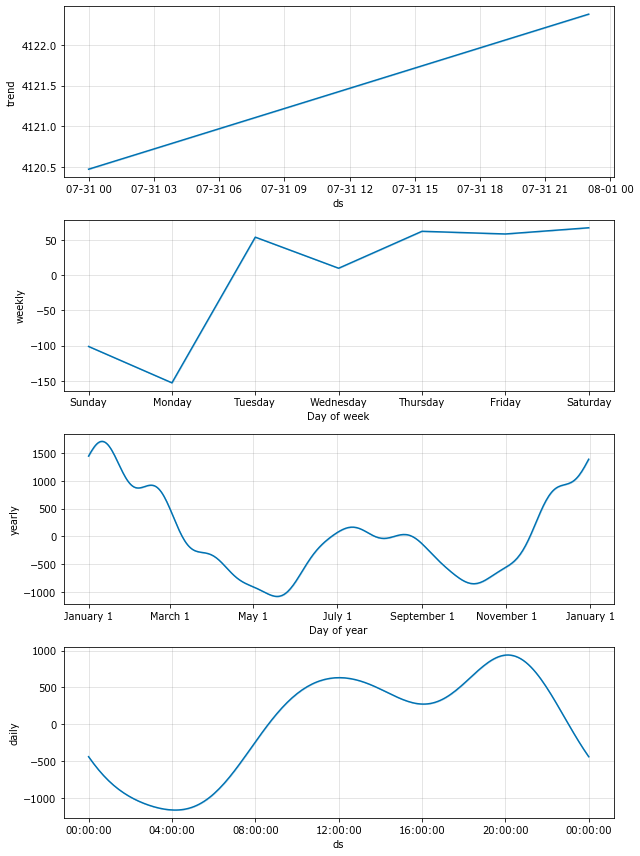

In [54]:
#store predictions
_ = prophet_model.plot_components(prophet_forecast)

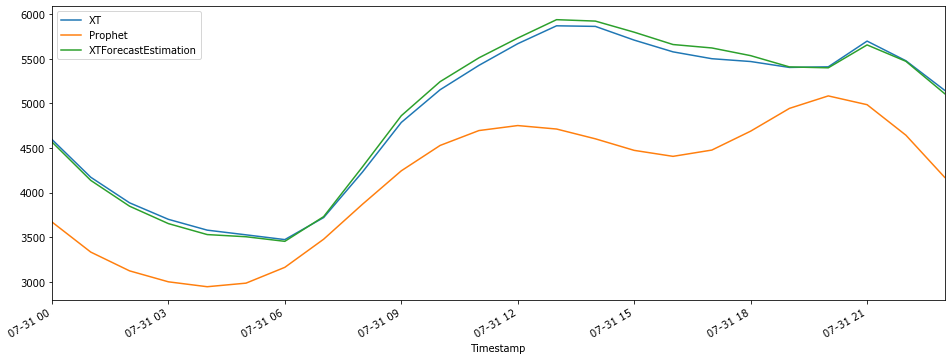

In [55]:
# Plot predictions against known values
fig, axes = plt.subplots(1, figsize=(16,6))
axes.plot(test.index, test['XT'], label='XT')
axes.plot(test.index, prophet_forecast['yhat'], label='Prophet', axes=axes)
final['XTForecastEstimation'].loc['2019-07-31'].plot(legend=True, axes=axes)
axes.autoscale(axis='x', tight=True)
axes.legend()

In [56]:
#calculate Error
from statsmodels.tools.eval_measures import mse,rmse
prophet_error= rmse(test['XT'], prophet_forecast['yhat'])

In [57]:
#worse
prophet_error

807.4593462643005

# More Feature Engineering

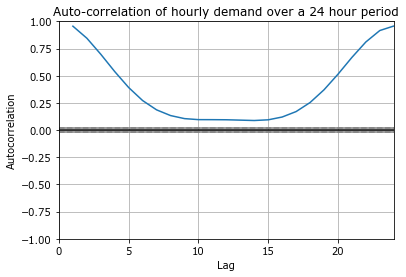

In [58]:
#The autocorrelation plot below shows the extent to which the demand variable correlates with itself at different intervals (lags). 
#This plot shows that demand is highly autocorrelated over the closest 6 hour period.
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(final2['XT'])
plt.xlim(0,24)
plt.title('Auto-correlation of hourly demand over a 24 hour period')
plt.show()

In [59]:
def generate_lagged_features(df, max_lag):
    for t in range(1, max_lag+1):
        df['XT_lag'+str(t)] = df['XT'].shift(t, freq='1H')

In [60]:
generate_lagged_features(final2, 6)

In [61]:
final2

,XT,Weekday,Holiday,XTForecastEstimation,XT_lag1,XT_lag2,XT_lag3,XT_lag4,XT_lag5,XT_lag6
Timestamp,,,,,,,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,3615.862294,1,1,3584.743969,3933.209685,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,3531.408073,1,1,3481.997027,3615.862294,3933.209685,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,3250.926682,1,1,3171.205588,3531.408073,3615.862294,3933.209685,NaN,NaN,NaN
2018-01-01 04:00:00,3027.204711,1,1,2874.047836,3250.926682,3531.408073,3615.862294,3933.209685,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-07-31 19:00:00,5403.155909,3,0,5409.007315,5469.492844,5501.081514,5577.958334,5709.639950,5863.460428,5870.075501
2019-07-31 20:00:00,5409.958805,3,0,5398.877004,5403.155909,5469.492844,5501.081514,5577.958334,5709.639950,5863.460428
2019-07-31 21:00:00,5698.581309,3,0,5655.686732,5409.958805,5403.155909,5469.492844,5501.081514,5577.958334,5709.639950


In [62]:
final2['Timestamp'] = final2.index

In [63]:
final2['Day'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%d'))
final2['Month'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%m'))
final2['Year'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%Y'))
final2['Hour'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%H'))

In [64]:
final2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13848 entries, 2018-01-01 00:00:00 to 2019-07-31 23:00:00
Freq: H
Data columns (total 15 columns):
XT                      13848 non-null float64
Weekday                 13848 non-null int64
Holiday                 13848 non-null int64
XTForecastEstimation    13848 non-null float64
XT_lag1                 13847 non-null float64
XT_lag2                 13846 non-null float64
XT_lag3                 13845 non-null float64
XT_lag4                 13844 non-null float64
XT_lag5                 13843 non-null float64
XT_lag6                 13842 non-null float64
Timestamp               13848 non-null datetime64[ns]
Day                     13848 non-null int64
Month                   13848 non-null int64
Year                    13848 non-null int64
Hour                    13848 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(6)
memory usage: 2.3 MB


In [65]:
final2.dropna(how='any', inplace=True)


In [66]:
final2

,XT,Weekday,Holiday,XTForecastEstimation,XT_lag1,XT_lag2,XT_lag3,XT_lag4,XT_lag5,XT_lag6,Timestamp,Day,Month,Year,Hour
Timestamp,,,,,,,,,,,,,,,
2018-01-01 06:00:00,2990.903843,1,1,2645.526199,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,3933.209685,2018-01-01 06:00:00,1,1,2018,6
2018-01-01 07:00:00,3048.662534,1,1,2778.846267,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,2018-01-01 07:00:00,1,1,2018,7
2018-01-01 08:00:00,3189.215049,1,1,3011.633638,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,2018-01-01 08:00:00,1,1,2018,8
2018-01-01 09:00:00,3575.720146,1,1,3690.084004,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,2018-01-01 09:00:00,1,1,2018,9
2018-01-01 10:00:00,4025.499981,1,1,4290.197566,3575.720146,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,2018-01-01 10:00:00,1,1,2018,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 19:00:00,5403.155909,3,0,5409.007315,5469.492844,5501.081514,5577.958334,5709.639950,5863.460428,5870.075501,2019-07-31 19:00:00,31,7,2019,19
2019-07-31 20:00:00,5409.958805,3,0,5398.877004,5403.155909,5469.492844,5501.081514,5577.958334,5709.639950,5863.460428,2019-07-31 20:00:00,31,7,2019,20
2019-07-31 21:00:00,5698.581309,3,0,5655.686732,5409.958805,5403.155909,5469.492844,5501.081514,5577.958334,5709.639950,2019-07-31 21:00:00,31,7,2019,21


In [67]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

In [68]:
#final_lstm_multi = final[['Weekday','XT','Holiday']]
final_lstm_multi = final2[['Weekday','XT','Day','Year','Month','Hour','Holiday','XT_lag1','XT_lag2','XT_lag3','XT_lag4','XT_lag5','XT_lag6']]
final_lstm_multi = pd.DataFrame(final_lstm_multi)
final_lstm_multi.head()

,Weekday,XT,Day,Year,Month,Hour,Holiday,XT_lag1,XT_lag2,XT_lag3,XT_lag4,XT_lag5,XT_lag6
Timestamp,,,,,,,,,,,,,
2018-01-01 06:00:00,1,2990.903843,1,2018,1,6,1,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,3933.209685
2018-01-01 07:00:00,1,3048.662534,1,2018,1,7,1,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294
2018-01-01 08:00:00,1,3189.215049,1,2018,1,8,1,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073
2018-01-01 09:00:00,1,3575.720146,1,2018,1,9,1,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682
2018-01-01 10:00:00,1,4025.499981,1,2018,1,10,1,3575.720146,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711


In [69]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
#ct = ColumnTransformer([
#        ("weekday", OneHotEncoder(categories='auto'), [0]),
#        ("xt", MinMaxScaler(feature_range=(0,1)), [1]),
#        ("holiday", "passthrough", [2])],
#        sparse_threshold=0)

ct = ColumnTransformer([
        ("weekday", OneHotEncoder(categories='auto'), [0])#,
       # ("xt", MinMaxScaler(feature_range=(0,1)), [1])
    ,("Day", OneHotEncoder(categories='auto'), [2])
    ,("Year", OneHotEncoder(categories='auto'), [3])
    ,("Month", OneHotEncoder(categories='auto'), [4])
    ,("Hour", OneHotEncoder(categories='auto'), [5])
    ,("holiday", "passthrough", [6])
    ,("XT_lag1", MinMaxScaler(feature_range=(0,1)), [7])
    ,("XT_lag2", MinMaxScaler(feature_range=(0,1)), [8])
    ,("XT_lag3", MinMaxScaler(feature_range=(0,1)), [9])
    ,("XT_lag4", MinMaxScaler(feature_range=(0,1)), [10])
    ,("XT_lag5", MinMaxScaler(feature_range=(0,1)), [11])
    ,("XT_lag6", MinMaxScaler(feature_range=(0,1)), [12])
],
       sparse_threshold=0)

In [70]:
final_lstm_multi['XT']=sc.fit_transform(final_lstm_multi[['XT']])

In [71]:
final_lstm_multi

,Weekday,XT,Day,Year,Month,Hour,Holiday,XT_lag1,XT_lag2,XT_lag3,XT_lag4,XT_lag5,XT_lag6
Timestamp,,,,,,,,,,,,,
2018-01-01 06:00:00,1,0.207558,1,2018,1,6,1,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,3933.209685
2018-01-01 07:00:00,1,0.218465,1,2018,1,7,1,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294
2018-01-01 08:00:00,1,0.245007,1,2018,1,8,1,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073
2018-01-01 09:00:00,1,0.317994,1,2018,1,9,1,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682
2018-01-01 10:00:00,1,0.402931,1,2018,1,10,1,3575.720146,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 19:00:00,3,0.663087,31,2019,7,19,0,5469.492844,5501.081514,5577.958334,5709.639950,5863.460428,5870.075501
2019-07-31 20:00:00,3,0.664372,31,2019,7,20,0,5403.155909,5469.492844,5501.081514,5577.958334,5709.639950,5863.460428
2019-07-31 21:00:00,3,0.718875,31,2019,7,21,0,5409.958805,5403.155909,5469.492844,5501.081514,5577.958334,5709.639950


In [72]:
dataset = ct.fit_transform(final_lstm_multi.values)
dataset[0:100:10]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

# LSTM

In [73]:
import tensorflow as tf

In [74]:
TRAIN_SPLIT = dataset.shape[0] * 2 // 3
TRAIN_SPLIT

9228

In [75]:
STEP = 1 # We are going to use all samples

In [76]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, 
                      step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [77]:
past_history = 15 * 24 # 10 days in the past
future_target = 24 # two days in the future

In [78]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [79]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('Target load to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (360, 83)
Target load to predict : (24,)


In [80]:
BATCH_SIZE = 256
BUFFER_SIZE = x_train_multi.shape[0]
BUFFER_SIZE

8868

In [81]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [82]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(16, 10))
    num_in = [ x for x in range(-int(history.shape[0]), 0, 1)]
    num_out = int(true_future.shape[0])

    plt.plot(num_in, np.array(history[:, -2]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 
             color='green',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 
                 color='brown',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

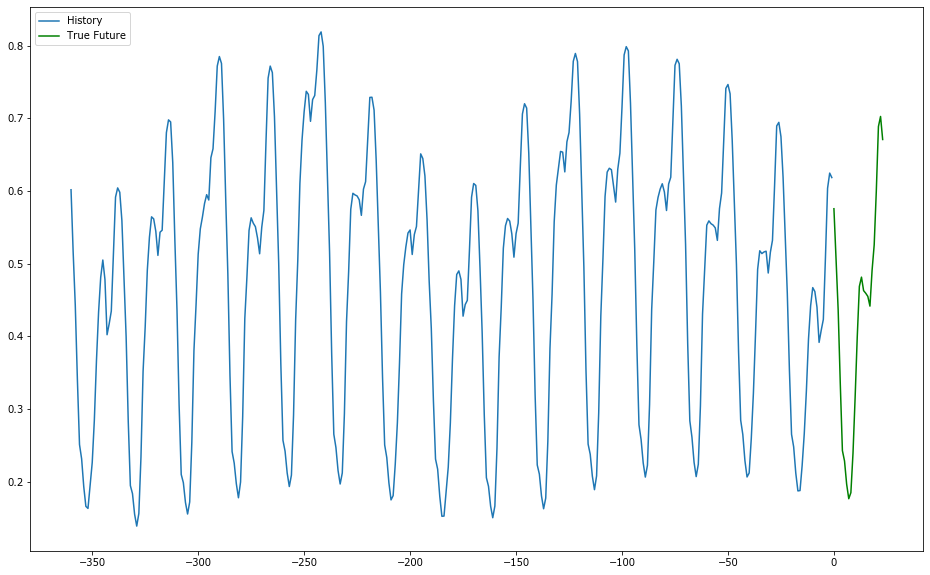

In [83]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [84]:
multivariate_model = tf.keras.models.Sequential()
multivariate_model.add(tf.keras.layers.LSTM(units=100, return_sequences=True, 
                                            input_shape=x_train_multi.shape[-2:]))
multivariate_model.add(tf.keras.layers.LSTM(units=100, return_sequences=True))
#multivariate_model.add(tf.keras.layers.LSTM(units=300, return_sequences=True))
multivariate_model.add(tf.keras.layers.LSTM(units=50))
multivariate_model.add(tf.keras.layers.Dense(units=24))
multivariate_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 360, 100)          73600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 360, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 24)                1224      
Total params: 185,424
Trainable params: 185,424
Non-trainable params: 0
_________________________________________________________________


In [85]:
multivariate_model.compile(optimizer='adam', loss='mean_squared_error')

In [86]:
for x, y in val_data_multi.take(1):
    print (multivariate_model.predict(x).shape)

(256, 24)


In [87]:
multivariate_history = multivariate_model.fit(train_data_multi, 
                                              epochs=20,
                                              steps_per_epoch=x_train_multi.shape[0] / BATCH_SIZE,
                                              validation_data=val_data_multi,
                                              validation_steps=50)

Train for 34.640625 steps, validate for 50 steps
Epoch 1/20
35/34 [==============================] - 167s 5s/step - loss: 0.0392 - val_loss: 0.0222
Epoch 2/20
35/34 [==============================] - 156s 4s/step - loss: 0.0146 - val_loss: 0.0123
Epoch 3/20
35/34 [==============================] - 157s 4s/step - loss: 0.0060 - val_loss: 0.0091
Epoch 4/20
35/34 [==============================] - 157s 4s/step - loss: 0.0037 - val_loss: 0.0068
Epoch 5/20
35/34 [==============================] - 160s 5s/step - loss: 0.0024 - val_loss: 0.0053
Epoch 6/20
35/34 [==============================] - 159s 5s/step - loss: 0.0018 - val_loss: 0.0046
Epoch 7/20
35/34 [==============================] - 160s 5s/step - loss: 0.0015 - val_loss: 0.0039
Epoch 8/20
35/34 [==============================] - 162s 5s/step - loss: 0.0013 - val_loss: 0.0046
Epoch 9/20
35/34 [==============================] - 162s 5s/step - loss: 0.0011 - val_loss: 0.0041
Epoch 10/20
35/34 [==============================] - 164s 5s

In [88]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

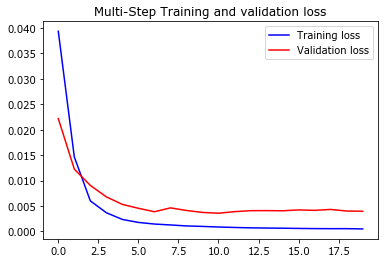

In [89]:
plot_train_history(multivariate_history, 'Multi-Step Training and validation loss')

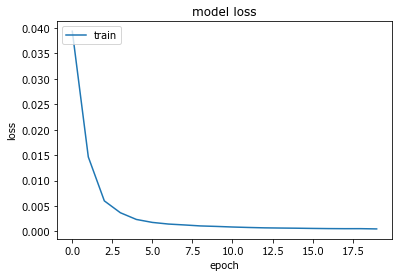

In [90]:
# summarize history for loss
plt.plot(multivariate_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

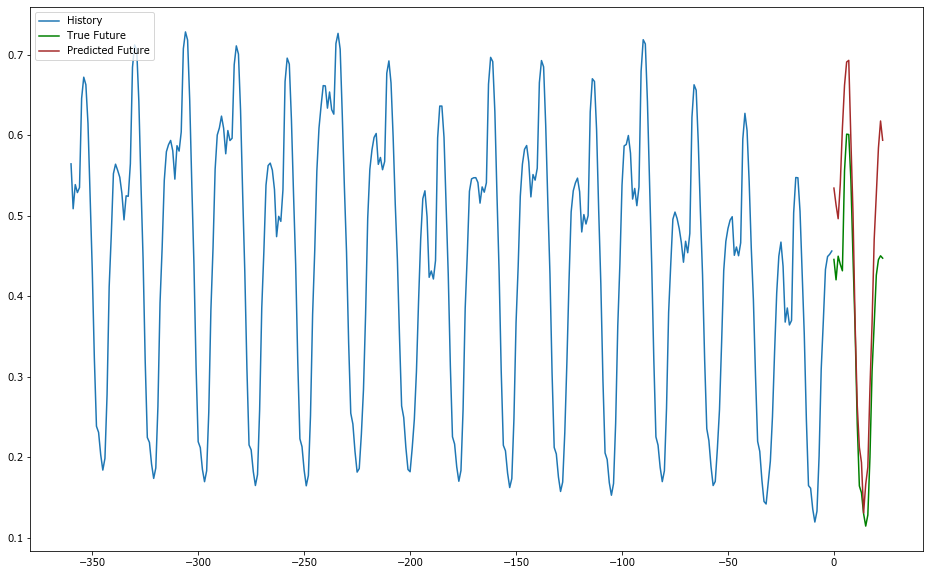

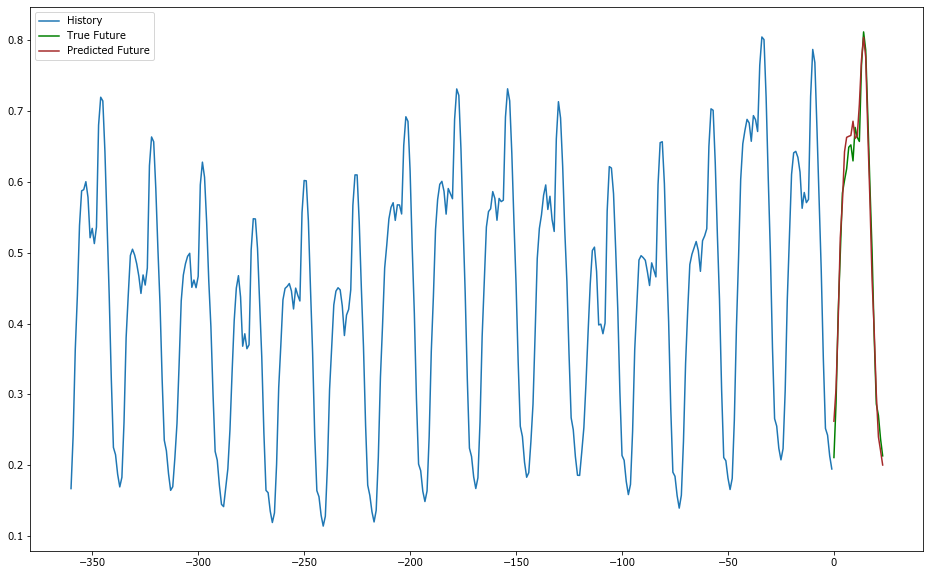

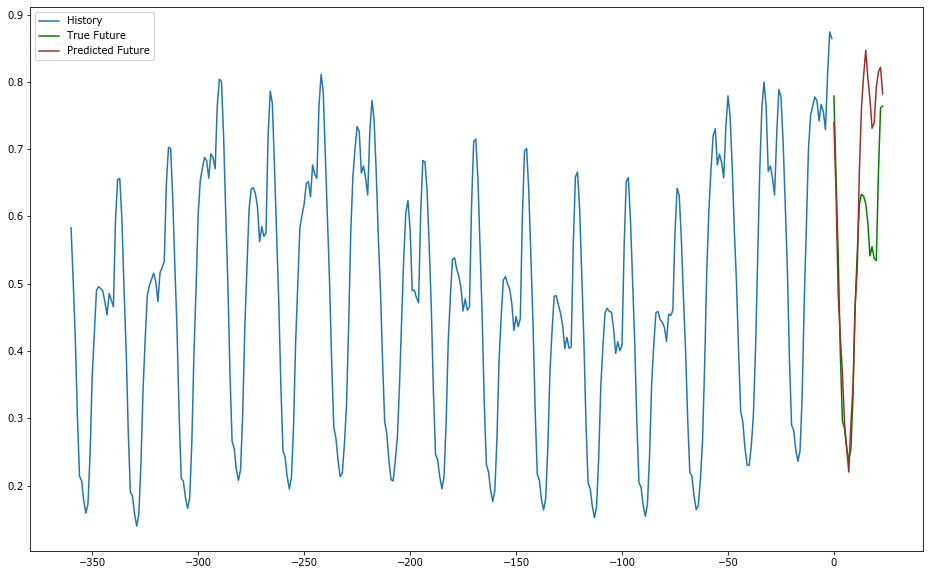

In [91]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multivariate_model.predict(x)[0])

In [92]:
from statsmodels.tools.eval_measures import mse,rmse
def evaluate_LSTM(z,y):
    scores=[]
    for i in range(0,z.shape[0]):
    
        trainPredict_dataset_like=np.zeros(shape=(len(z[i]),3))
        trainPredict_dataset_like[:,1]=z[i]
        Predict=sc.inverse_transform(trainPredict_dataset_like)[:,1]
    
        actual_dataset_like=np.zeros(shape=(len(np.asarray(y[i])),3))
        actual_dataset_like[:,1]=np.asarray(y[i])
        actual=sc.inverse_transform(actual_dataset_like)[:,1]
        scores.append(rmse(Predict,actual))
    
    return scores, sum(scores) / len(scores)

In [93]:
evaluate_LSTM(multivariate_model.predict(x),y)

([667.2275445682778,
  666.9982871348004,
  665.4431682535385,
  670.1480459683883,
  675.5072848962552,
  691.8676439838835,
  687.146163082113,
  683.9747290551185,
  676.0598070181483,
  664.5054476668662,
  653.9886310472702,
  647.5053956415431,
  645.5059879343419,
  640.4799181468336,
  614.9252280951065,
  587.4709344010954,
  559.4784344490591,
  514.8970131991721,
  453.5066308450045,
  412.51532171272675,
  364.6690062824011,
  289.7787453405178,
  298.01643085480185,
  364.16887772005487,
  368.63706770449215,
  350.5844059938273,
  355.24157594694447,
  350.6109072157437,
  330.26503839457445,
  321.56564265673086,
  316.2114525052632,
  331.0228056360453,
  348.716008158344,
  340.8357057466402,
  334.0287685177953,
  316.59611025859783,
  290.7027712022684,
  274.2190768887783,
  269.3708788300506,
  278.7320641268556,
  298.0504915386685,
  296.615363876552,
  322.2056710666345,
  352.0052314517879,
  379.6094697322055,
  398.6802669496129,
  397.2915421055904,
  408.42

# ML

In [94]:
#final2=pd.read_csv("final3.csv")

In [95]:
final2

,XT,Weekday,Holiday,XTForecastEstimation,XT_lag1,XT_lag2,XT_lag3,XT_lag4,XT_lag5,XT_lag6,Timestamp,Day,Month,Year,Hour
Timestamp,,,,,,,,,,,,,,,
2018-01-01 06:00:00,2990.903843,1,1,2645.526199,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,3933.209685,2018-01-01 06:00:00,1,1,2018,6
2018-01-01 07:00:00,3048.662534,1,1,2778.846267,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,2018-01-01 07:00:00,1,1,2018,7
2018-01-01 08:00:00,3189.215049,1,1,3011.633638,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,2018-01-01 08:00:00,1,1,2018,8
2018-01-01 09:00:00,3575.720146,1,1,3690.084004,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,2018-01-01 09:00:00,1,1,2018,9
2018-01-01 10:00:00,4025.499981,1,1,4290.197566,3575.720146,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,2018-01-01 10:00:00,1,1,2018,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 19:00:00,5403.155909,3,0,5409.007315,5469.492844,5501.081514,5577.958334,5709.639950,5863.460428,5870.075501,2019-07-31 19:00:00,31,7,2019,19
2019-07-31 20:00:00,5409.958805,3,0,5398.877004,5403.155909,5469.492844,5501.081514,5577.958334,5709.639950,5863.460428,2019-07-31 20:00:00,31,7,2019,20
2019-07-31 21:00:00,5698.581309,3,0,5655.686732,5409.958805,5403.155909,5469.492844,5501.081514,5577.958334,5709.639950,2019-07-31 21:00:00,31,7,2019,21


In [96]:
X_train=final2[:9240][['Day','Year','Month','Hour','Weekday','Holiday','XT_lag1','XT_lag2','XT_lag3','XT_lag4','XT_lag5','XT_lag6']]
y_train=final2[:9240]['XT']

In [97]:
X_test=final2[9240:][['Day','Year','Month','Hour','Weekday','Holiday','XT_lag1','XT_lag2','XT_lag3','XT_lag4','XT_lag5','XT_lag6']]
y_test=final2[9240:]['XT'].to_frame()

In [98]:
y_their=final2[9240:]['XTForecastEstimation']

In [99]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

In [100]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
ct_x = ColumnTransformer([

        ("Day", OneHotEncoder(categories='auto'), [0]),
        ("Year", OneHotEncoder(categories='auto'), [1]),
        ("Month", OneHotEncoder(categories='auto'), [2]),
        ("Hour", OneHotEncoder(categories='auto'), [3]),
        ("weekday", OneHotEncoder(categories='auto'), [4]),
        ("holiday", OneHotEncoder(categories='auto'), [5])])

In [101]:
y = sc.fit_transform(y_train.values.reshape(-1, 1))

In [102]:
X = ct_x.fit_transform(X_train.values)
Xt = ct_x.transform(X_test.values)

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as boost
from sklearn.model_selection import cross_val_score

In [104]:
#create function for mean square error
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [105]:
#Lasso
model_lassoCV=LassoCV()
model_lassoCV.fit(X_train,y_train)
rmse_lassoCV=rmse_cv(model_lassoCV).mean()
rmse_lassoCV

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW

169.19750928225307

In [106]:
#RidgeCV
model_RidgeCV = RidgeCV()
model_RidgeCV.fit(X_train, y_train)
rmse_RidgeCV = rmse_cv(model_RidgeCV).mean()
rmse_RidgeCV

168.10927207653904

In [107]:
#KernerlRidge
model_KernelRidge=KernelRidge()
model_KernelRidge.fit(X_train,y_train)
rmse_KernelRidge=rmse_cv(model_KernelRidge).mean()
rmse_KernelRidge


167.64922874252818

In [108]:
#ElasticNet
model_ElasticNet=ElasticNet()
model_ElasticNet.fit(X_train,y_train)
model_ElasticNet=rmse_cv(model_ElasticNet).mean()
model_ElasticNet

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117887966.71095303, tolerance: 854178.9637788405
  positive)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101402074.54020469, tolerance: 756430.9628145557
  positive)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103337617.87265274, tolerance: 785179.3447551653
  positive)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

167.53476360823927

In [109]:
#RandomForestRegressor
RFMregressor = RandomForestRegressor(n_estimators = 500, random_state = 0, n_jobs = -1) 
RFMregressor.fit(X_train,y_train)
RFMregressor=rmse_cv(RFMregressor).mean()
RFMregressor


114.39486012865503

In [110]:
#XGBRegressor
tuned_model_boost = boost.XGBRegressor(learning_rate=.05, max_depth=3, n_estimators=500) 
tuned_model_boost.fit(X_train,y_train)
tuned_model_boost=rmse_cv(tuned_model_boost).mean()
tuned_model_boost

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:47:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:47:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


126.34163009896709

In [111]:
#GradientBoosting
GBregressor = GradientBoostingRegressor()
GBregressor.fit(X_train,y_train)
GBregressor=rmse_cv(GBregressor).mean()
GBregressor

143.81512462497994

# GridSearch RF

In [112]:
from sklearn.model_selection import GridSearchCV

In [113]:
rfc=RandomForestRegressor(random_state = 0,n_estimators=700,
                          min_samples_leaf=1,min_samples_split=2,max_features='auto',max_depth=20)

param_grid = { 
    'n_estimators': [200, 300,400,500,600,700,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 15, 100],
    'max_depth' : [5,10,15,20,25,30],
    'min_samples_leaf' : [1, 2, 5, 10]
}


In [114]:
#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
#CV_rfc.fit(X_train, y_train)
#print(CV_rfc.best_params_)
#{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}

In [115]:
final=rfc.fit(X_train,y_train)

In [116]:
#make predictions
y_1= final.predict(X_test)

In [117]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(y_1, y_test['XT'])

In [118]:
OurError

98.54249852489843

In [119]:
TheirError= rmse(y_their, y_test['XT'])

In [120]:
TheirError

142.7895891803268